# Importado de librerias

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
plt.style.use('classic')
sns.set_theme(style="whitegrid")
sns.set_context("paper")

paletteE =['#00377e', '#006B8F', '#06889B', '#FEAE6C', '#FE6C31', '#F93414']
paletteE_r = paletteE[::-1]
paletteT =['#011F51', '#06889B',  '#FE6C31']
%matplotlib inline

# Lectura de datos

### Funcion de lectura

In [4]:
def read_trajs(path : str) -> dict:
    '''
    Esta funcion lee la direccion con las salidas de la dinamica molecular (concatenada) y las guarda en un diccionario.
    '''
    df = {}
    dfs = []
    sticks = ['traj_stick.out', 'traj_stickearly.out', 'traj_sticklate.out']
    for stick in sticks:    
        if os.path.getsize(path + stick) > 0:
            dfs.append(pd.read_csv(path + stick, delim_whitespace=True, header=None))
    if len(dfs) == 0:
        df['stick'] = dfs[0]
    if len(dfs) > 0:
        df['stick'] = pd.concat(dfs, ignore_index=True)
    del(dfs)
    df['stick'].columns = ['ncoup', 'nt', 't', 'nreb', 'nsubh', 'ptad', 'V']
    df['stick'] = df['stick'].sort_values(by='ncoup')
    df['stick'].columns = ['ncoup', 'nt', 't', 'nreb', 'nsubh', 'ptad', 'V']

    df['admol'] = pd.read_csv(path + 'traj_admol.out', delim_whitespace=True, header=None)
    df['admol'].columns = ['ncoup','nt','t','rmax','V','vint']
    df['refl'] = pd.read_csv(path + 'traj_refl.out', delim_whitespace=True, header=None)
    df['refl'].columns = ['ncoup','nt','t','nreb','V','tlf'] 
    return df


### Lectura

In [6]:
pathRS = 'data/RS/1-concat/'
path0 = 'data/0/1-concat/'
energias =  ['Ei0.6_outputs/', 'Ei1.0_outputs/', 'Ei1.4_outputs/']
trajs0 = {}
trajsRS = {}
for Ei in energias:
    trajs0[str(Ei[2:5])] = read_trajs(path0+Ei)
    trajsRS[str(Ei[2:5])] = read_trajs(pathRS+Ei)
E_incidencia = ['0.6', '1.0', '1.4']
tipo_traj = ['stick', 'admol', 'refl']

In [7]:
display(trajs0['1.0']['stick'].head(5))
display(trajs0['1.0']['admol'].head(5))
display(trajs0['1.0']['refl'].head(5))

,ncoup,nt,t,nreb,nsubh,ptad,V
0,74,1074,0.2146,0,2,51,1.474938
1,84,1106,0.2210,1,4,50,1.187536
2,87,1073,0.2144,1,1,49,1.527178
3,112,1125,0.2248,1,1,50,1.502067
4,116,989,0.1976,0,1,51,1.405986


,ncoup,nt,t,rmax,V,vint
0,1,5002,1.0002,1.207495,0.746116,-0.029699
1,4,5036,1.0070,1.140552,0.561296,-0.000000
2,7,5002,1.0002,1.212187,0.888073,-0.025687
3,8,5014,1.0026,1.160048,1.197704,-0.000000
4,9,5002,1.0002,1.187437,0.843891,-0.027041


,ncoup,nt,t,nreb,V,tlf
0,2,2980,0.5958,1,1.462089,0.0
1,3,3627,0.7252,1,0.613818,0.0
2,5,3154,0.6306,1,1.271560,0.0
3,6,2215,0.4428,1,0.973038,0.0
4,10,2965,0.5928,1,1.039464,0.0


In [8]:
trajs0['1.4']['refl'].t.min()

0.3582

In [9]:
nombres = {}
nombres['stick'] = {}
nombres['stick']['ncoup'] = 'numero de trayectoria'
nombres['stick']['t'] = 'tiempo [ps]'
nombres['stick']['nreb'] = 'cantidad de rebotes'
nombres['stick']['nsubh'] = 'Hidrogeno disociado???'
nombres['stick']['ptad'] = 'Disociacion sobre platino num'
nombres['stick']['V'] = 'Potencial [eV]'

nombres['admol'] = {}
nombres['admol']['ncoup'] = 'numero de trayectoria'
nombres['admol']['t'] = 'tiempo [ps]'
nombres['admol']['rmax'] = 'rmax' #length of the longest molecular bond
nombres['admol']['V'] = 'Potencial [eV]'
nombres['admol']['vint'] = 'Potencial de interacción [eV]'

nombres['refl'] = {}
nombres['refl']['ncoup'] = 'numero de trayectoria'
nombres['refl']['t'] = 'tiempo [ps]'
nombres['refl']['nreb'] = 'cantidad de rebotes'
nombres['refl']['V'] = 'Potencial [eV]'
nombres['refl']['tlf'] = 'lifetime in the surface'


# Definicion de funciones auxiliares

In [10]:
def make_hist(trajs : dict, tipo : str, variable : str, T : str):
    '''
    Grafica de Histograma
    '''

    num_filas = 2
    num_columnas = 3

    fig, axes = plt.subplots(num_filas, num_columnas,  figsize=(16, 12))
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        row = i // num_columnas
        col = i % num_columnas
        axes[row, col].hist(data, rwidth=0.8, align="mid", color=paletteE[i])
        axes[row, col].set_title(f'Energia de incidencia {E} eV')
        axes[row, col].set_xlabel(nombres[tipo][variable])
        axes[row, col].set_ylabel('Cuentas')
    fig.suptitle(f'Histograma por energia de {nombres[tipo][variable]} para casos de {tipo} a {T}K')
    plt.tight_layout()
    return axes



def make_boxplot(trajs : dict, tipo : str, variable : str, T : str, outliers=False, cuentas = False):
    ''' 
    Caja (Box): [Q1,Q3] La caja del boxplot representa el rango intercuartílico (IQR).
                El IQR abarca el 50% central de los datos y se extiende desde el primer cuartil (Q1) hasta el tercer cuartil (Q3).
                En términos de desviación estándar, esto equivale a aproximadamente 1.35σ.

    Línea Mediana (Mediana): La mediana (Q2) es el valor que divide el conjunto de datos en dos partes iguales. 
                En términos de desviación estándar, la mediana es el valor que está a 0σ del centro de la distribución y  representa el 50% de la muestra en cada lado.

    Bigotes (Whiskers):[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] Los bigotes representan la extensión de los datos dentro del rango aceptable antes de considerarlos valores atípicos.
                La mayoría de los datos se encuentran dentro de aproximadamente 1.5σ de la mediana(), lo que abarca aproximadamente el 99% de los datos.

    Puntos (Outliers): Los valores atípicos, si los hay, se representan como puntos individuales. 
                Estos son valores que se encuentran significativamente más allá de los ±1.5σ desde la caja.
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    # Creamos una lista para almacenar los DataFrames individuales
    dataframes = []

    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,palette=paletteE[::-1], ax=ax)
    else:
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,palette=paletteE[::-1], sym="", ax=ax)
    boxplot.set_title(f'Boxplot de {nombres[tipo][variable]} para {tipo} por Energía a {T}K (Sin Outliers)')
    
    plt.xlabel(nombres[tipo][variable])
    plt.ylabel('Energía [eV]')
    return ax



# Caso T = 50K

### Sobre que platino se disocia

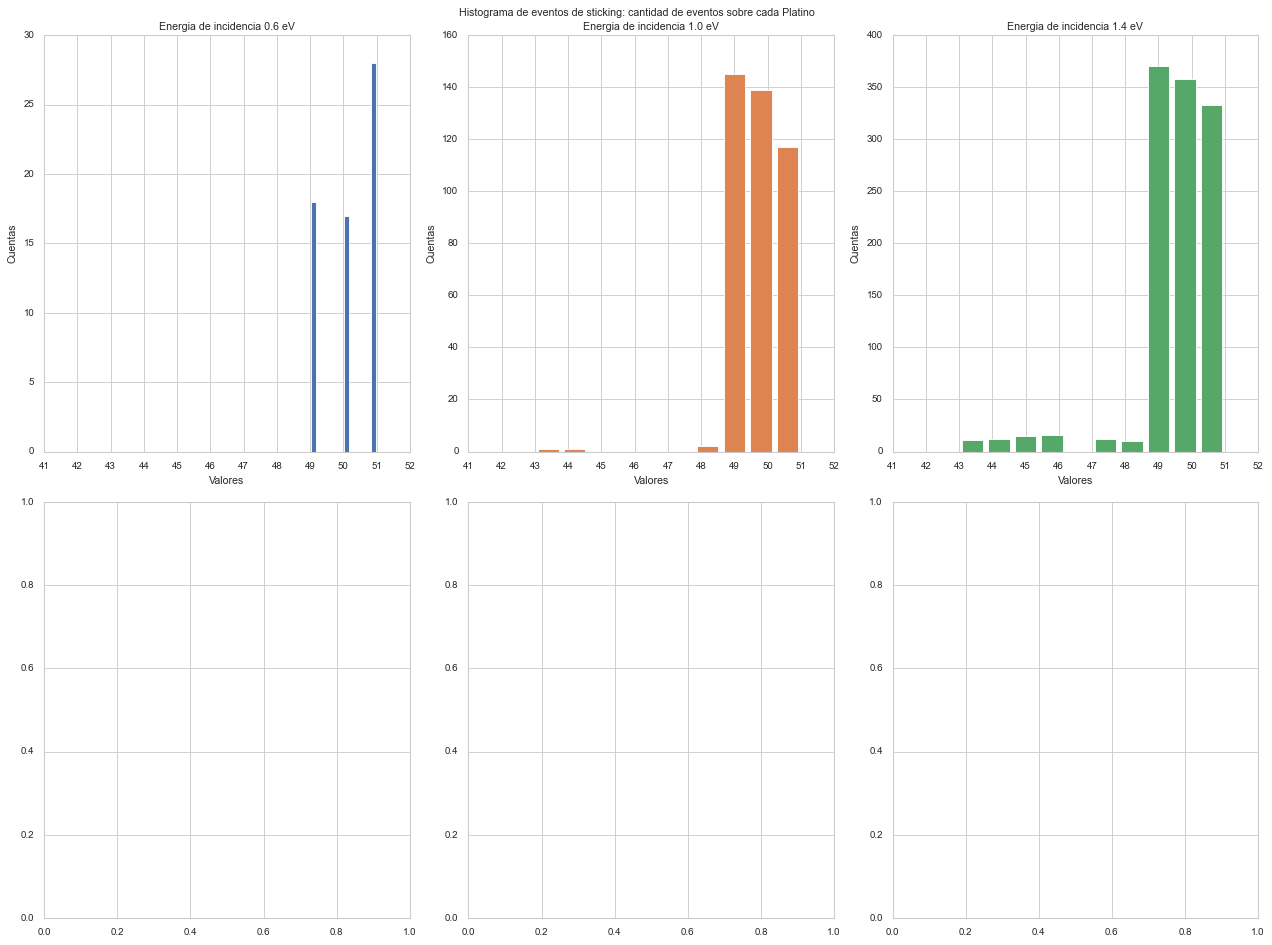

In [11]:
valores_discretos = list(range(41, 53))

num_filas = 2
num_columnas = 3
bar_width = 0.3

fig, axes = plt.subplots(num_filas, num_columnas,  figsize=(16, 12))
for i, E in enumerate(E_incidencia):
    data = trajs0[E]['stick']['ptad']
    row = i // num_columnas
    col = i % num_columnas
    axes[row, col].hist(data, rwidth=0.8, align="mid", color=f'C{i}')
    axes[row, col].set_title(f'Energia de incidencia {E} eV')
    axes[row, col].set_xlabel('Valores')
    axes[row, col].set_ylabel('Cuentas')
    axes[row, col].set_xticks(valores_discretos)

fig.suptitle('Histograma de eventos de sticking: cantidad de eventos sobre cada Platino')
plt.tight_layout()
plt.show()

### Tiempo

# Multi Boxplot

In [12]:
def make_boxplot_stick_refl(trajs : dict, variable : str, T : str, ax, outliers=False, cuentas = False):
    ''' 
    Caja (Box): [Q1,Q3] La caja del boxplot representa el rango intercuartílico (IQR).
                El IQR abarca el 50% central de los datos y se extiende desde el primer cuartil (Q1) hasta el tercer cuartil (Q3).
                En términos de desviación estándar, esto equivale a aproximadamente 1.35σ.

    Línea Mediana (Mediana): La mediana (Q2) es el valor que divide el conjunto de datos en dos partes iguales. 
                En términos de desviación estándar, la mediana es el valor que está a 0σ del centro de la distribución y  representa el 50% de la muestra en cada lado.

    Bigotes (Whiskers):[Q1 - 1.5 * IQR, Q3 + 1.5 * IQR] Los bigotes representan la extensión de los datos dentro del rango aceptable antes de considerarlos valores atípicos.
                La mayoría de los datos se encuentran dentro de aproximadamente 1.5σ de la mediana(), lo que abarca aproximadamente el 99% de los datos.

    Puntos (Outliers): Los valores atípicos, si los hay, se representan como puntos individuales. 
                Estos son valores que se encuentran significativamente más allá de los ±1.5σ desde la caja.
    '''
    # Creamos una lista para almacenar los DataFrames individuales
    dataframes = []
    tipo = 'stick'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,color = 'orange', ax=ax)
    else:
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,color = 'orange', sym="", ax=ax)
    del(dataframes)
    
    dataframes = []
    tipo = 'refl'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,color = 'cyan', ax=ax)
    else:
        boxplot = sns.boxplot(x='Valores',y='Energía', data=df_combined,color = 'cyan', sym="", ax=ax)
    boxplot.set_title(f'Boxplot de {nombres[tipo][variable]} para {tipo} por Energía a {T}K (Sin Outliers)')
    
    plt.xlabel(nombres[tipo][variable])
    plt.ylabel('Energía [eV]')
    return ax

def make_violin(trajs : dict, variable : str, T : str, ax, outliers=False, cuentas = False):
    # Creamos una lista para almacenar los DataFrames individuales
    dataframes = []
    tipo = 'stick'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.violinplot(x='Valores',y='Energía', data=df_combined, color = 'orange', ax=ax, s=1, alpha=0.3)
    else:
        boxplot = sns.violinplot(x='Valores',y='Energía', data=df_combined, color = 'orange', ax=ax, s=1, alpha=0.3)
    del(dataframes)
    
    dataframes = []
    tipo = 'refl'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.violinplot(x='Valores',y='Energía', data=df_combined, color = 'lightblue', ax=ax, s=1, alpha=0.3)
    else:
        boxplot = sns.violinplot(x='Valores',y='Energía', data=df_combined, color = 'lightblue',ax=ax, s=1, alpha=0.3)
    boxplot.set_title(f'Boxplot de {nombres[tipo][variable]} para {tipo} por Energía a {T}K (Sin Outliers)')
    
    plt.xlabel(nombres[tipo][variable])
    plt.ylabel('Energía [eV]')
    return ax

In [13]:
def make_strip(trajs : dict, variable : str, T : str, ax, outliers=False, cuentas = False):
    # Creamos una lista para almacenar los DataFrames individuales
    dataframes = []
    tipo = 'stick'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.stripplot(x='Valores',y='Energía', data=df_combined, color = 'red', ax=ax, s=1)
    else:
        boxplot = sns.stripplot(x='Valores',y='Energía', data=df_combined, color = 'red', ax=ax, s=1)
    del(dataframes)
    
    dataframes = []
    tipo = 'refl'
    for i, E in enumerate(E_incidencia):
        data = trajs[E][tipo][variable]
        df = pd.DataFrame({'Valores': data, 'Energía': E})
        dataframes.append(df)

    # Concatenamos todos los DataFrames en uno solo
    df_combined = pd.concat(dataframes, ignore_index=True)
    # Ordenar el DataFrame por Energía de manera ascendente
    df_combined = df_combined.sort_values(by='Energía', ascending=False)

    if cuentas:
        print(f'Cuentas de configuraciones de {tipo} a temperatura {T} K')
        display(df_combined.groupby('Energía').agg('count'))
    # Creamos un boxplot con Seaborn y ocultamos los outliers
    if outliers:        
        boxplot = sns.stripplot(x='Valores',y='Energía', data=df_combined, color = 'blue', ax=ax, s=0.5, alpha=0.3)
    else:
        boxplot = sns.stripplot(x='Valores',y='Energía', data=df_combined, color = 'blue',ax=ax, s=0.5, alpha=0.3)
    boxplot.set_title(f'Dispersión de {nombres[tipo][variable]} para stick y refl por Energía a {T}K')
    
    plt.xlabel(nombres[tipo][variable])
    plt.ylabel('Energía [eV]')
    return ax

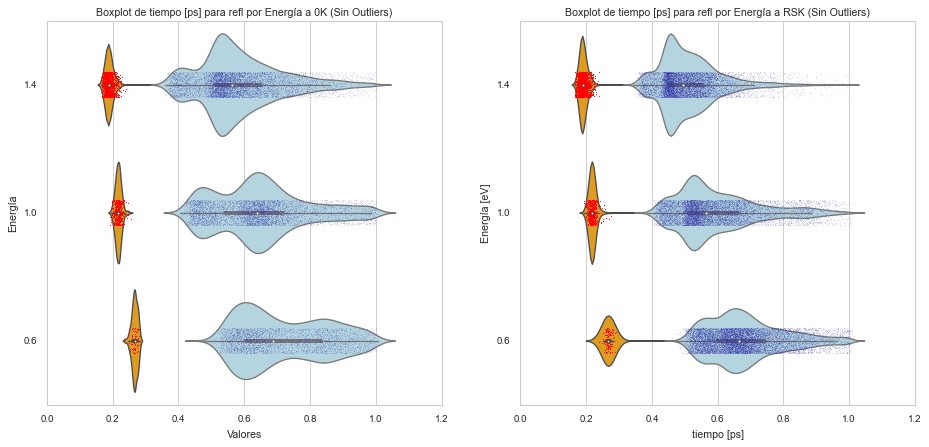

In [20]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
make_strip(trajs0,'t'  ,'0',ax= ax[0])
make_violin(trajs0,'t' ,'0',ax=ax[0])
make_strip(trajsRS,'t' ,'RS',ax= ax[1])
make_violin(trajsRS,'t','RS',ax=ax[1])
plt.show()